In [1]:
import sys
import pandas as pd
import numpy as np
import scanpy as sc
import scipy
import sklearn
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as clr
sys.path.append("..")
import spasne

Loading data and transforming it to AnnData object

In [2]:
df_data = pd.read_csv('data/human_BreastCancer1272_data_pc200.csv',sep=",",header=0,na_filter=False,index_col=0) 
df_pixel = pd.read_csv('data/human_BreastCancer1272_pixels.csv',sep=",",header=0,na_filter=False,index_col=0)  
df_labels = pd.read_csv('data/human_BreastCancer1272_labels.csv',sep=",",header=0,na_filter=False,index_col=0) 
df_labels_subregions = pd.read_csv('data/human_BreastCancer1272_subregion_labels.csv',sep=",",header=0,na_filter=False,index_col=0) 
df_PCs = pd.DataFrame(list(df_data.columns), index = df_data.columns, columns =['PCs'] )
adata = sc.AnnData(X = df_data, obs = df_pixel, var = df_PCs)
# Annotation of five cell types
adata.obs['gt'] = list(df_labels['gt'])
# Annotation of subtypes according to both cell types and spatial locations
sub_labels = list(df_labels_subregions['labels'])

Visualizing spots from image

/home/chentang/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'gt' as categorical


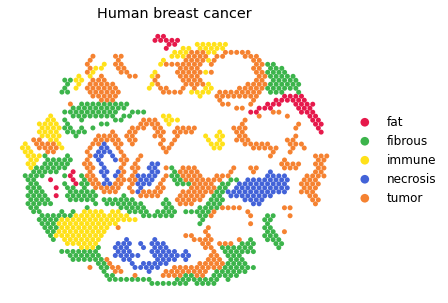

In [3]:
matplotlib.rcParams['font.size'] = 12.0
fig, axes = plt.subplots(1, 1, figsize=(6,5))
sz = 100

plot_color=['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', \
            '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#ffd8b1', '#800000', '#aaffc3', '#808000', '#000075', '#000000', '#808080', '#ffffff', '#fffac8']
domains="gt"
num_celltype=len(adata.obs[domains].unique())
adata.uns[domains+"_colors"]=list(plot_color[:num_celltype])
titles = 'Human breast cancer'
ax=sc.pl.scatter(adata,alpha=1,x="y_pixel",y="x_pixel",color=domains,title=titles ,color_map=plot_color,show=False,size=sz,ax = axes)
ax.axis('off')
ax.axes.invert_yaxis()


Calculating data distances and spatial distances

In [4]:
N = df_data.shape[0]
X = np.array(df_data)
dist_sq = euclidean_distances(X, X)
dist_sq = (dist_sq + dist_sq.T) / 2.0
dist_data = scipy.spatial.distance.squareform(dist_sq)
X_spa = np.array(df_pixel)
dist_sq = euclidean_distances(X_spa,X_spa)
dist_sq = (dist_sq + dist_sq.T) / 2.0
dist_spatial = scipy.spatial.distance.squareform(dist_sq)
df_pixel = df_pixel.astype(np.float64)

Performing t-SNE embedding

In [5]:
tsne_pos = spasne.run_spasne(df_data, alpha = 0.0, randseed = 5)
dist_sq = euclidean_distances(tsne_pos, tsne_pos)
dist_sq = (dist_sq + dist_sq.T)/2
dist_model = scipy.spatial.distance.squareform(dist_sq)
# Measuring gene expression presrvation
(r1,_) = scipy.stats.pearsonr(dist_data, dist_model)
# Measuring spatial structure presrvation
(r2,_) = scipy.stats.pearsonr(dist_spatial, dist_model)
# Calculating silhouette score based on annotation of subtypes
ss = sklearn.metrics.silhouette_score(tsne_pos,sub_labels)
quant_eval_tsne = [r1,r2,ss]
adata.obs['tsne_pos_x'] = tsne_pos[:,0]
adata.obs['tsne_pos_y'] = tsne_pos[:,1]


Visualizing spots from t-SNE embedding

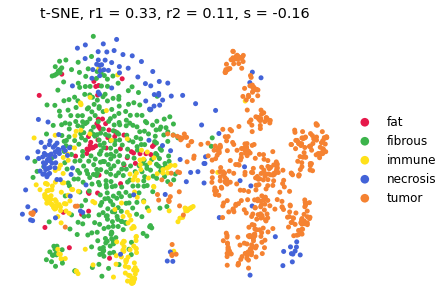

In [6]:
matplotlib.rcParams['font.size'] = 12.0
fig, axes = plt.subplots(1, 1, figsize=(6,5))
domains="gt"
num_celltype=len(adata.obs[domains].unique())
adata.uns[domains+"_colors"]=list(plot_color[:num_celltype])
titles = 't-SNE, ' + 'r1 = %.2f'% quant_eval_tsne[0] + ', r2 = %.2f'%quant_eval_tsne[1] + ', s = %.2f'%quant_eval_tsne[2]
ax=sc.pl.scatter(adata,alpha=1,x="tsne_pos_x",y="tsne_pos_y",color=domains,title=titles,color_map=plot_color,show=False,size=sz,ax = axes)
ax.axis('off')
ax.axes.invert_xaxis()
ax.axes.invert_yaxis()

Performing SpaSNE embedding

In [7]:
alpha = 10.0
beta = 5.0
spasne_pos = spasne.run_spasne(df_data, pixels = df_pixel, alpha = alpha, beta = beta, randseed = 5)
dist_sq = euclidean_distances(spasne_pos, spasne_pos)
dist_sq = (dist_sq + dist_sq.T)/2
dist_model = scipy.spatial.distance.squareform(dist_sq)
(r1,_) = scipy.stats.pearsonr(dist_data, dist_model)
(r2,_) = scipy.stats.pearsonr(dist_spatial, dist_model)
ss = sklearn.metrics.silhouette_score(spasne_pos,sub_labels)
quant_eval_spasne = [r1,r2,ss]
adata.obs['spasne_pos_x'] = spasne_pos[:,0]
adata.obs['spasne_pos_y'] = spasne_pos[:,1]

Visualizing spots from SpaSNE embedding

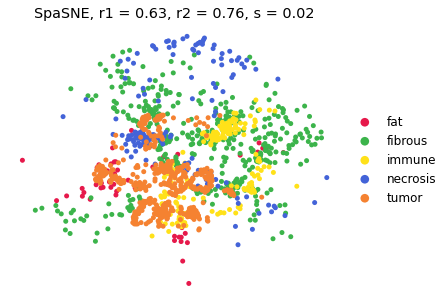

In [8]:
matplotlib.rcParams['font.size'] = 12.0
fig, axes = plt.subplots(1, 1, figsize=(6,5))
domains="gt"
num_celltype=len(adata.obs[domains].unique())
adata.uns[domains+"_colors"]=list(plot_color[:num_celltype])
titles = 'SpaSNE, ' + 'r1 = %.2f'% quant_eval_spasne[0] + ', r2 = %.2f'%quant_eval_spasne[1] + ', s = %.2f'%quant_eval_spasne[2]
ax=sc.pl.scatter(adata,alpha=1,x="spasne_pos_x",y="spasne_pos_y",color=domains,title=titles,color_map=plot_color,show=False,size=sz,ax = axes)
ax.axis('off')
ax.axes.invert_xaxis()
ax.axes.invert_yaxis()
